# Text Classification with BigDL : A Tutorial

In this tutorial, we will walk you through an example of training a neural net to classify text documents using Python API of BigDL. The example is a typical text classfication problem using the [news20 dataset ](http://qwone.com/~jason/20Newsgroups/). The dataset is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups. We will use BigDL to train a model using part of the dataset, and classify the rest, identifying the correct newsgroup label for each newsgroup document. We will show you how to use BigDL together with other python libraries and use visualizations to monitor and inspect the training process. 
 
The contents of this tutorial are listed below. 

* [Setup the Working Environment](#Setup-the-Working-Environment)
   * [Install prerequists](#Install-prerequists)
   * [Start Jupyter](#Start-Jupyter)
   * [Start TensorBoard](#Start-TensorBoard)
* [Initialize BigDL](#Initialize-BigDL)
* [Prepare datasets](#Prepare-Datasets)
   * [Load data](#Load-data)
   * [Prepare the train/val dataset](#Prepare-the-train/val-dataset)
* [Train a neural network](#Train-a-neural-network)
   * [Define the model](#Define-the-model)
   * [Train the model](#Train-the-model)
* [Evaluate the prediction result](#Evaluate-the-prediction-result)
* [Visualize the Training Process](#Visualize-the-Training-Process)
   * [using Tensorboard](#using-Tensorboard)
   * [using inlined plotting of notebook](#using-inlined-plotting-of-notebook)

# Setup the Working Environment

##  Install prerequists
Before running this example, you need to have some prerequists installed. 
* Install `Spark`. This example is tested with **Spark 1.6**. Refer to [Spark Official Site](http://spark.apache.org/) for detailed instructions. 
* Download and build `BigDL`. Follow the instructions in [BigDL Build Guide](https://github.com/intel-analytics/BigDL/wiki/Build-Page).
* Install the Python development environment and related python libraries.
    * Install `python` and `pip`. This example works with **Python 2.7.x and pip2**.
    * Install python libraries using pip
       * Install `jupyter`. Jupyter is a notebook environment for you to execute this ipynb notebook. If you are not familiar with jupyter or met with any problems during installation, refer to the [Jupyter Docs](https://jupyter.readthedocs.io/en/latest/index.html). 
```bash
pip install jupyter
```
       * Install `tensorboard`. Tensorboard is used to visualize traces and statistics of BigDL training and validation process. Refer to [Tensorboard Installation Guide for BigDL](https://github.com/intel-analytics/BigDL/blob/master/spark/dl/src/main/scala/com/intel/analytics/bigdl/visualization/README.md) for detailed instructions.
```bash
pip install tensorboard
```
       * Install dependency python packages used in this example
```bash
pip install numpy scipy pandas scikit-learn matplotlib seaborn wordcloud
```

## Start Jupyter

* BigDL python API is based on pyspark. To enable communication with Spark cluster through python API, jupyter server needs to be launched using *pyspark* instead of using the regular way. Refer to [BigDL Python API Guide](https://github.com/intel-analytics/BigDL/blob/master/pyspark/dl/README.md#launch-jupyter-on-standalone-cluster) for detailed instructions on how to launch Jupyter with pyspark and BigDL. 

* After sucessfully launching jupyter, you will be able to navigate to the notebook dashboard using a browser. You can find the exact url in the console output when you started jupyter. By default, the dashboard url is 
```
http://your_node:8888/
```
or if token is enabled, the dashbook url may look like below. For more details about security of Jupyter, please refer to [Jupyter Security doc](http://jupyter-notebook.readthedocs.io/en/latest/security.html)
```
http://your_node:8888/tree?token=abcded...
```
* You can open this notebook(.ipynb) inside the jupyter dashboard and try execute the following code sections. 

## Start TensorBoard
Tensorboard is a web-based visualization tool which we will use to visualize/inspect the process of training and validation. If you don't want to visualize the training process, you can skip this section.  
During the training, BigDL will write traces and statistics in protobuf format in a designated local directory (on spark client node). The structure of the log directory looks like below
```
/logdir/run1/train
/logdir/run1/validation
/logdir/run2/train
/logdir/run2/validation
```
We can launch Tensorboard anytime to point to the root log directory (as long as the log directory already exists) and visualize the learning curves alongside the training. To make illustration easier, we create the root directory before head(actually if you didn't, BigDL will create it for you when writing logs). Later when setting up the training, we will tell BigDL to write logs into this directory. For detailed usage guide about visualization using Tensorboard, refer to [BigDL Programming Guide, Visualization via Tensorboard section](https://github.com/intel-analytics/BigDL/wiki/Programming-Guide#visualization-via-tensorboard)

Now follow the steps below to start tensorboard
 * create the root log directory
```bash
mkdir /tmp/bigdl_summaries
```
 * After created the root log directory, we are now able to launch TensorBoard using below command. 
```bash
tensorboard --logdir=/tmp/bigdl_summaries
```
 * Now you can navigate to the tensorboard dashboard using a browser. You can find the url in the console output after tensorboard is successfully launched. By default the url is
```
http://your_node:6006
```

# Initialize BigDL

Now we start the real sections.

First of all, we need to import some dependent python libraries. These are either python standard libraries or 3rd party libraries, convinient for visualization and data analytics. 

In [1]:
import itertools
import re
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
import pandas as pd
from wordcloud import WordCloud
import random as rd
import datetime as dt

Then, import libraries from BigDL python API. 
  * `dataset` contains some convinient tools for downloading and simple processing of common datasets such as MNIST and news20.
  * `nn.layer` contains definitions of layers and activations. Refer to for a list of defined layers [layer.py](https://github.com/intel-analytics/BigDL/blob/master/pyspark/dl/nn/layer.py) 
  * `nn.criterion` contains definitions of critierions (i.e. loss functions). Refer to [BigDL Criterions](https://github.com/intel-analytics/BigDL/wiki/Criterions) for a list of supported critierions. 
  * `optim.optimizer` contains the optimizers for training a neural net.
  * `util` libraries are some utitlies. `Sample`, in particular, is a class that contains two fields, `features`, and `label`, both of which are ndarrays. Training and prediction both accept an `RDD[Sample]` as input.  

In [2]:
from dataset import news20
from nn.layer import *
from nn.criterion import *
from optim.optimizer import *
from util.common import *
from util.common import Sample

Call init_engine() to initialize BigDL Engine. Now the initialization work is done. For details about engine initialization, refer to [BigDL Programming Guide, Engine section](https://github.com/intel-analytics/BigDL/wiki/Programming-Guide#engine)

In [3]:
init_engine()

# Prepare Datasets

## Load data

First we set some global variables for the following processing. 

Then we use the `news20` tool provided in `dataset` to load new20 dataset and word embeddings (here we use [GloVe embedding](https://nlp.stanford.edu/projects/glove/)). `get_news20` will download the dataset and parse it into a list of tuples, each tuple in the format of (news text string, newsgroup id). `get_glove_w2v` will download the GloVe word embeddings and parse it into a dict `w2v`.  

In [4]:
batch_size = 128
embedding_dim = 50
sequence_len = 50
max_words = 1000 
training_split = 0.8

In [5]:
texts = news20.get_news20('/tmp/news20data')
w2v = news20.get_glove_w2v(dim=embedding_dim)
len(texts),len(w2v)

Found 19997 texts.


(19997, 400000)

Now let's show one of newsgroup text samples using wordcloud and the corresponding class id.

the newsgroup of the text is 19


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


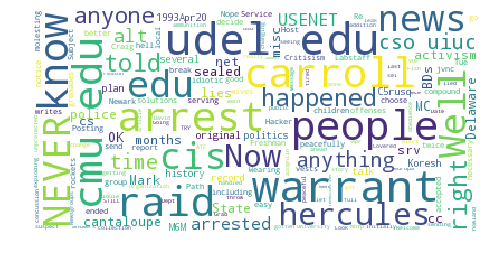

In [6]:
rand_idx=rd.randrange(0, len(texts))
wordcloud = WordCloud(max_font_size=40,background_color="white").generate(texts[rand_idx][0])
print "the newsgroup of the text is %d"%(texts[rand_idx][1])
plt.imshow(wordcloud)
plt.axis("off");

Then we do some text analysis and broadcast the word countings and word embeddings to Spark cluster using `sc`. - When using pyspark to launch jupyter, a SparkContext object is already created for you as `sc`. 

In [7]:
data_rdd = sc.parallelize(texts, 2)

# break the text corpus into tokens (words)
def text_to_words(review_text):
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    words = letters_only.lower().split()
    return words
# calcualte the frequency of words in each text corpus, sort by frequency, and assign an id to each word
def analyze_texts(data_rdd):
    return data_rdd.flatMap(lambda (text, label): text_to_words(text)) \
        .map(lambda word: (word, 1)).reduceByKey(lambda a, b: a + b) \
        .sortBy(lambda (w, c): - c).zipWithIndex() \
        .map(lambda ((w, c), i): (w, (i + 1, c))).collect()
        
word_to_ic = analyze_texts(data_rdd)
# take the top "max_words" most frequent words while remove the top 10 ( may not be meaningful,e.g. "of","the")
#broad case the word count info 
word_to_ic = dict(word_to_ic[10: max_words])
bword_to_ic = sc.broadcast(word_to_ic)

#prepare and broadcast word embeddings 
filtered_w2v = {w: v for w, v in w2v.items() if w in word_to_ic}
bfiltered_w2v = sc.broadcast(filtered_w2v)

## Prepare the train/val dataset

In the following code, we use the word embedding and word count statistics to prepare the input samples (`RDD[Sample]`). Then we split it into training and validation set.

In [8]:
def prepare_samples(data_rdd,
                    sequence_len,
                    embedding_dim,
                    bword_to_ic,
                    bfiltered_w2v):
    print "preparing samples with embedding_dim = %s, sequence_len=%s"%(embedding_dim,sequence_len)
    def pad(l, fill_value, width):
        """
        pad the embedding to required length
        pad([1, 2, 3, 4, 5], 0, 6)
        """
        if len(l) >= width:
            return l[0: width]
        else:
            l.extend([fill_value] * (width - len(l)))
            return l
    def to_vec(token, b_w2v, embedding_dim):
        """
        word to vec
        """
        if token in b_w2v:
            return b_w2v[token]
        else:
            return pad([], 0, embedding_dim)  
    def to_sample(vectors, label, embedding_dim,sequence_len):
        """
        assemble the features (embeddings of words in each text sample) and label into samples
        """
        flatten_features = list(itertools.chain(*vectors)) # flatten nested list
        features = np.array(flatten_features, dtype='float').reshape(
            [sequence_len, embedding_dim]).transpose(1, 0)
        return Sample.from_ndarray(features, np.array(label))
    
    tokens_rdd = data_rdd.map(lambda (text, label):
                              ([w for w in text_to_words(text) if
                                w in bword_to_ic.value], label))
    padded_tokens_rdd = tokens_rdd.map(
        lambda (tokens, label): (pad(tokens, "##", sequence_len), label))

    vector_rdd = padded_tokens_rdd.map(lambda (tokens, label):
                                       ([to_vec(w, bfiltered_w2v.value,
                                                embedding_dim) for w in
                                         tokens], label))
    sample_rdd = vector_rdd.map(
        lambda (vectors, label): to_sample(vectors, label, embedding_dim,sequence_len))
    print('Generated Samples')
    return sample_rdd

sample_rdd = prepare_samples(data_rdd, sequence_len, embedding_dim,bword_to_ic,bfiltered_w2v)
#split train val sets
train_rdd, val_rdd = sample_rdd.randomSplit([training_split, 1-training_split])

preparing samples with embedding_dim = 50, sequence_len=50
Generated Samples


# Train a neural network

## Define the model

Now we define a nerual net model, layer by layer.

In [9]:
def build_model(class_num=news20.CLASS_NUM,
                embedding_dim=embedding_dim,
                sequence_len=sequence_len):
    print "building model with embedding_dim = %s, sequence_len=%s"%(embedding_dim,sequence_len)
    model = Sequential()
    model.add(Reshape([embedding_dim, 1, sequence_len]))
    model.add(SpatialConvolution(embedding_dim, 128, 5, 1).set_name('conv1'))
    model.add(ReLU())
    model.add(SpatialMaxPooling(5, 1, 5, 1))
    model.add(SpatialConvolution(128, 128, 5, 1).set_name('conv2'))
    model.add(ReLU())
    model.add(SpatialMaxPooling(5, 1, 5, 1))
    model.add(Reshape([128]))
    model.add(Linear(128, 100).set_name('fc1'))
    model.add(Linear(100, class_num).set_name('fc2'))
    model.add(LogSoftMax())
    return model

model = build_model()

building model with embedding_dim = 50, sequence_len=50
creating: createSequential
creating: createReshape
creating: createSpatialConvolution
creating: createReLU
creating: createSpatialMaxPooling
creating: createSpatialConvolution
creating: createReLU
creating: createSpatialMaxPooling
creating: createReshape
creating: createLinear
creating: createLinear
creating: createLogSoftMax


## Train the model

To train a model, we first create and configure a trainer (`Optimizer`) for training.  Then, use ```Optimizer.optimize()``` to launch the acutal training process. 

For details of how to configure an optimizer, refer to [BigDL Programming Guide, Optimizer section](https://github.com/intel-analytics/BigDL/wiki/Programming-Guide#optimizer). 

In order to use Tensorboard to visualize the optimization process, we need to configure BigDL to write logs into the log directory - we have created one in [Start TensorBoard section](#Start-TensorBoard) :```/tmp/bigdl_summaries``` . The logdir is actually set into `TrainSummary` and `ValidationSummary`. Run below code and you will find the output log indicating where the logs will be written to. The output looks like below
```
...
optimize summary will be write to : /tmp/bigdl_summaries/adagrad-yyyymmdd-HHMMSS
...
```
In my run, for example, the summary logs are written into `/tmp/bigdl_summaries/adagrad-20170401-171227`. My appname is `adagrad-20170401-171227`. Run your training for some time, and you will be able to find your run in Tensorboard dashboard. In following sections we will show you what the visualizations look like.

When the training is finished, you will obtain a trained model `trained_model`. 

`TrainSummary` and `ValidationSummary` are the utilities we use to configure the log writting procedure. They can also be used to retrieve the logs for further processing after the training. We will see usage in the following sections. 

In [10]:
def create_optimizer(model,
                     app_name,
                     logdir='/tmp/bigdl_summaries',
                     batch_size=batch_size,
                     lr=0.01,
                     lrd=0.0002,
                     optim="Adagrad",
                     val=["Top1Accuracy","Loss"],
                     max_epoch=2):
    print "optimize summary will be write to :",logdir+'/'+app_name
    state = {"batchSize": batch_size,
         "learningRate": lr,
         "learningRateDecay": lrd}
    #configure optimizer
    optimizer = Optimizer(
        model=model,
        training_rdd=train_rdd,
        criterion=ClassNLLCriterion(),
        end_trigger=MaxEpoch(max_epoch),
        batch_size=batch_size,
        optim_method=optim,
        state=state)

    optimizer.setvalidation(
        batch_size=batch_size,
        val_rdd=val_rdd,
        trigger=EveryEpoch(),
        val_method=val
    )
    train_summary = TrainSummary(log_dir=logdir, app_name=app_name)
    train_summary.set_summary_trigger("Parameters", SeveralIteration(50))
    val_summary = ValidationSummary(log_dir=logdir, app_name=app_name)
    optimizer.set_train_summary(train_summary)
    optimizer.set_val_summary(val_summary)
    return optimizer,train_summary,val_summary

print 'Start to train the model'
#configure optimizer
optimizer,train_summary,val_summary = create_optimizer(model,'adagrad-'+ dt.datetime.now().strftime("%Y%m%d-%H%M%S"))
trained_model = optimizer.optimize()
print "Optimization Done."

Start to train the model
optimize summary will be write to : /tmp/bigdl_summaries/adagrad-20170405-164341
creating: createClassNLLCriterion
creating: createMaxEpoch
creating: createOptimizer
creating: createEveryEpoch
creating: createTrainSummary
creating: createSeveralIteration
creating: createValidationSummary
Optimization Done.


# Evaluate the prediction result

Now let's use `trained_model` to make predictions on `val_rdd`. `y_pred` are the predicted labels on entire validation set and `y_true` are the true labels. 

We compare the result of predicted labels and true labels using 2 metrics: *accuracy score* and *confusion matrix* ( both are provided in `sklearn.metrics`). If you're not familar with confusion matrix, refer to [Wikipedia Definition of Confusion Matrix](https://en.wikipedia.org/wiki/Confusion_matrix)

In [11]:
predictions = trained_model.predict(val_rdd).collect()

def map_predict_label(l):
    return np.array(l).argmax()
def map_groundtruth_label(l):
    return l[0] - 1

y_pred = np.array([ map_predict_label(s) for s in predictions])

y_true = np.array([map_groundtruth_label(s.label) for s in val_rdd.collect()])

The prediction accuracy is 95.80%


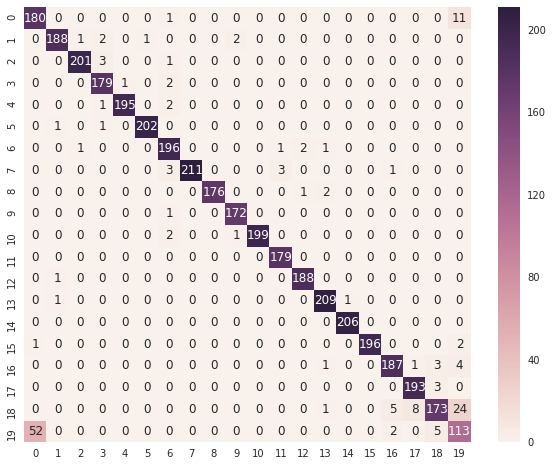

In [12]:
acc = accuracy_score(y_true, y_pred)
print "The prediction accuracy is %.2f%%"%(acc*100)

cm = confusion_matrix(y_true, y_pred)
cm.shape
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (10,8))
sn.heatmap(df_cm, annot=True,fmt='d');

# Visualize the Training Process

## using Tensorboard

In Tensorboard dashboard, you will be able to read the visualizations of each run. `Loss` and `Throughput` curves are under `SCALARS` tab; `weights`, `bias`, `gradientWeights` and `gradientBias` are under `DISTRIBUTIONS` and `HISTOGRAMS` tabs, illustrated as below. For more details of how to use Tensorboard for visualization, refer to [BigDL wiki](https://github.com/intel-analytics/BigDL/wiki/Programming-Guide#visualization-via-tensorboard)

<img src="https://github.com/shane-huang/BigDL/raw/notebookdemo2/notebook/tensorboard_scalar.png" width="800px"  class="pull-left" style="display: inline-block; margin: 0px;"/>
<img src="https://github.com/shane-huang/BigDL/raw/notebookdemo2/notebook/tensorboard_histo1.png" width="800px" class="pull-left" style="display: inline-block; margin: 0px;"/>
<img src="https://github.com/shane-huang/BigDL/raw/notebookdemo2/notebook/tensorboard_histo2.png" width="800px" class="pull-left" style="display: inline-block; margin: 0px;"/>

## using inlined plotting of notebook

The training and validation metrics history can also be retrieved using `read_scalar` of `TrainSummary` or `ValidationSummary`. They are in the format of ndarrays and can be visualized using inlined plotting libs such as matplotlib, illustrated as below. Validation summary is recorded every epoch, so `Loss` and `Top1Accuracy` in `val_summary` has only 2 data points.

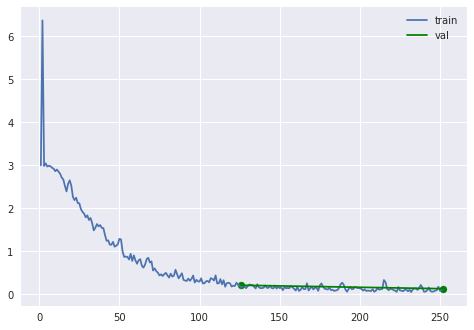

In [13]:
loss_adagrad = np.array(train_summary.read_scalar("Loss"))
valloss_adagrad  = np.array(val_summary.read_scalar("Loss"))
# each event data has 3-dimension value, in the form of (iteration_count, value, timestamp)
plt.plot(loss_adagrad[:,0],loss_adagrad[:,1],label='train')
plt.plot(valloss_adagrad[:,0],valloss_adagrad[:,1],label='val',color='green')
plt.scatter(valloss_adagrad[:,0],valloss_adagrad[:,1],color='green')
plt.legend();

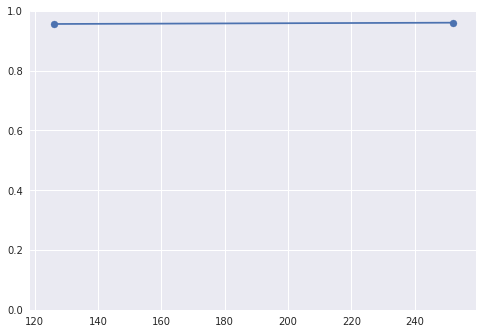

In [15]:
top1 = np.array(val_summary.read_scalar("Top1Accuracy"))
plt.ylim(0,1)
plt.plot(top1[:,0],top1[:,1],label='top1')
plt.scatter(top1[:,0],top1[:,1]);